# Билет 5

## Номер 2

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

%matplotlib inline
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE.upper()} device")

Using CUDA device


332


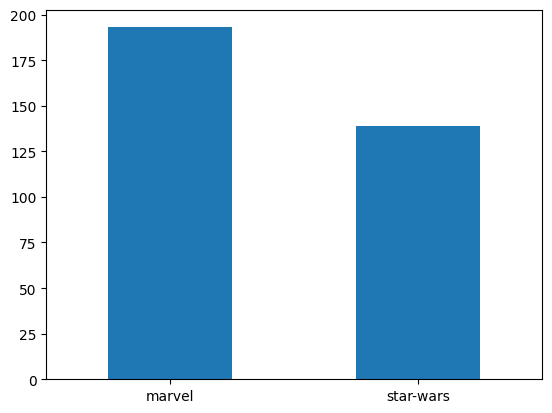

In [2]:
transform = transforms.Compose([
    transforms.Resize(size=(100, 100)),  # уменьшение размеров картинки
    transforms.ToTensor(),  # из картинки в тензор
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # нормализация (испортит RGB цвета)
])
dataset = ImageFolder("../data/images/chars", transform=transform)

vc = pd.value_counts(dataset.targets)
vc.index = [dataset.classes[i] for i in vc.index]
print(len(dataset))
vc.plot.bar(rot=0);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


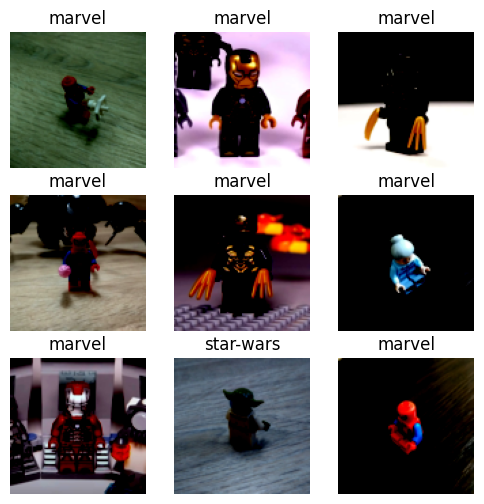

In [3]:
_, axes = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in zip(torch.randperm(len(dataset)), axes.flatten()):
    img, target = dataset[i]
    ax.axis("off")
    ax.set_title(dataset.classes[target])
    ax.imshow(img.permute(1, 2, 0))

Задача: определить является ли фигурка LEGO персонажем из MARVEL или STAR-WARS.

Выборка неплохо сбалансированная.

Разделение выборки на обучающую 75% и тестовую 25%:

In [4]:
test_size = round(0.25 * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, lengths=(train_size, test_size))
len(train_dataset), len(test_dataset)

(249, 83)

Cверточная нейронная сеть

In [5]:
class CNNClassifier(nn.Module):

    def __init__(self, num_channels: int, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            # свертка
            nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            # нормализация для ускорения обучения
            nn.BatchNorm2d(32),
            # фун-ия активации
            nn.ReLU(True),
            # уменьшение вдвое
            nn.MaxPool2d(2),
            # свертка
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            # нормализация для ускорения обучения
            nn.BatchNorm2d(64),
            # фун-ия активации
            nn.ReLU(True),
            # уменьшение вдвое
            nn.MaxPool2d(2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))
        self.classifier = nn.Sequential(
            nn.Linear(64 * 5 * 5, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [6]:
def get_weights(targets: torch.Tensor) -> torch.Tensor:
    _, counts = targets.unique(return_counts=True)
    return counts.max() / counts


net = CNNClassifier(
    num_channels=train_dataset[0][0].size(0),
    num_classes=len(dataset.classes),
).to(DEVICE)
weights = get_weights(torch.tensor([target for _, target in train_dataset], device=DEVICE))
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(net.parameters(), lr=0.0002)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

net

CNNClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
  (classifier): Sequential(
    (0): Linear(in_features=1600, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [7]:
@torch.no_grad()
def test_loop(dataloader, model, loss_fn):
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader)
    return loss_fn(y_pred, y_true).item(), metrics.accuracy_score(y_true.cpu(), y_pred.argmax(1).cpu())


@torch.no_grad()
def get_y_true_y_pred(model, dataloader):
    model.eval()
    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x)
        y_test.append(y.unsqueeze(1))
        y_pred.append(pred)

    return torch.flatten(torch.vstack(y_test)), torch.vstack(y_pred)

In [8]:
train_losses, train_accuracy_list = [], []
test_losses, test_accuracy_list = [], []
epochs = 20
for epoch in range(epochs):
    # ============ train loop ============
    net.train()
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    avg_loss, avg_accuracy = 0, 0
    for batch, (x, y) in enumerate(train_dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = net(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_true = torch.flatten(y).detach().cpu()
        y_pred = torch.flatten(pred.argmax(1)).detach().cpu()
        accuracy = metrics.accuracy_score(y_true, y_pred)
        avg_loss += loss
        avg_accuracy += accuracy
    train_loss, train_accuracy = (avg_loss / num_batches).item(), avg_accuracy / num_batches
    print(f"[{epoch + 1:>2}/{epochs}] Train: loss={train_loss:.6f}, accuracy={train_accuracy:.4f}")
    train_losses.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    # ============ test loop ============
    test_loss, test_accuracy = test_loop(test_dataloader, net, loss_fn)
    test_losses.append(test_loss)
    test_accuracy_list.append(test_accuracy)

[ 1/15] Train: loss=0.710166, accuracy=0.5482
[ 2/15] Train: loss=0.665050, accuracy=0.6315
[ 3/15] Train: loss=0.650198, accuracy=0.6089
[ 4/15] Train: loss=0.641915, accuracy=0.6519
[ 5/15] Train: loss=0.655452, accuracy=0.5495
[ 6/15] Train: loss=0.601448, accuracy=0.6471
[ 7/15] Train: loss=0.568319, accuracy=0.6931
[ 8/15] Train: loss=0.587250, accuracy=0.6871
[ 9/15] Train: loss=0.513787, accuracy=0.6940
[10/15] Train: loss=0.500067, accuracy=0.7869
[11/15] Train: loss=0.490354, accuracy=0.7556
[12/15] Train: loss=0.454810, accuracy=0.7752
[13/15] Train: loss=0.430082, accuracy=0.8181
[14/15] Train: loss=0.433239, accuracy=0.8212
[15/15] Train: loss=0.377334, accuracy=0.8672
[16/15] Train: loss=0.391204, accuracy=0.8229
[17/15] Train: loss=0.339514, accuracy=0.8659
[18/15] Train: loss=0.312341, accuracy=0.8954
[19/15] Train: loss=0.290720, accuracy=0.8867
[20/15] Train: loss=0.242731, accuracy=0.9102


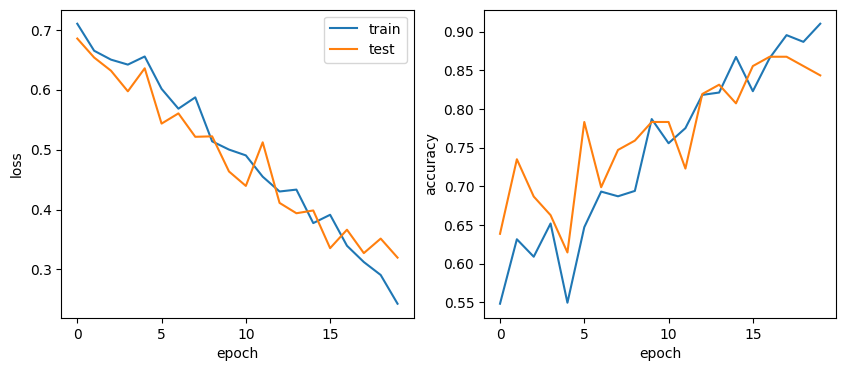

In [9]:
_, axes = plt.subplots(1, 2, figsize=(10, 4))
epochs = torch.arange(len(train_losses))

axes[0].plot(epochs, train_losses)
axes[0].plot(epochs, test_losses)
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].legend(["train", "test"])

axes[1].plot(epochs, train_accuracy_list)
axes[1].plot(epochs, test_accuracy_list)
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("accuracy");

Проблема переобучения не наблюдается, возможно можно докинуть epoch - accuracy растет losses падают

In [10]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader)
y_true, y_pred = y_true.cpu(), y_pred.argmax(1).cpu()

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=dataset.classes,
    colorbar=False,
    xticks_rotation=0,
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(3.5, 3.5)

print(metrics.classification_report(y_true, y_pred, target_names=dataset.classes, zero_division=True))


KeyboardInterrupt



Качество модели отличное (точность 83%). Из-за сбалансированности выборки все метрики близки. Модель отлично работает на обоих классах.

## Задача 3

In [ ]:
start, end = -5, 5
X = torch.arange(start, end + 0.001, 0.001)
f = lambda x: x ** 3 - 6 * x + torch.pi
Y = f(X)
plt.plot(X.detach(), Y.detach());

In [ ]:
def solution(x, lr=0.05, eps=0.000001):  # градиентный спуск
    i = 0
    x = torch.tensor(x, dtype=torch.float, requires_grad=True)
    history = []
    while True:
        if i % 200 == 0:
            print(x)
        i += 1

        if x < start or x > end:
            start_t, end_t = torch.tensor(start), torch.tensor(end)
            _, x = min((f(history[-2]), history[-2]), (f(start_t), start_t), (f(end_t), end_t))
            history.append(x.detach().clone())
            return history

        history.append(x.detach().clone())
        y = f(x)
        y.backward()
        with torch.no_grad():
            x -= lr * x.grad
            if torch.abs(x - history[-1]) <= eps:
                history.append(x.detach().clone())
                break
        x.grad.zero_()
    return history

In [ ]:
history = solution(4)
x = history[-1]
x, y = x.item(), f(x).item()
print(x, y)
plt.plot(X.detach(), Y.detach())
plt.scatter(x, y, color="r");

In [ ]:
history = solution(-2)
x = history[-1]
x, y = x.item(), f(x).item()
print(x, y)
plt.plot(X.detach(), Y.detach())
plt.scatter(x, y, color="r");

В зависимости от стартовой позиции будет найден локальный или глобальный минимум.